In [14]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from glob import glob
import os
import json

import seaborn as sns
import pandas as pd
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline 

In [15]:
from sklearn.datasets import load_files
from keras.utils import np_utils

In [16]:
def load_dataset(path):
    data=load_files(path)
    dog_files=np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
test_files, test_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/test')
train_files, train_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/train')
valid_files, valid_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/valid')

In [25]:
dog_names = [item[20:-1] for item in sorted(glob("/content/drive/MyDrive/dogImages/dogImages/train/*/*"))]

In [ ]:
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

In [27]:
import random
random.seed(8675309)

In [29]:
# load filenames for human images
human_files = np.array(glob("/content/drive/MyDrive/lfw/lfw/*/*"))
dog_files = np.array(glob('/content/drive/MyDrive/dogImages/dogImages/*/*/*'))
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Detect Humans


Number of faces detected: 1


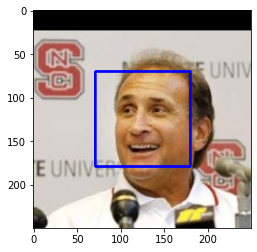

In [30]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

# Detect Cat faces

In [31]:
# load filenames for cat images
cat_files = np.array(glob("/content/drive/MyDrive/Cat/*/*"))

# print number of images in each dataset
print('There are %d total cat images.' % len(cat_files))

There are 13906 total cat images.


(225, 300, 3)
[[ 60 150  67  67]]
Number of faces detected: 1


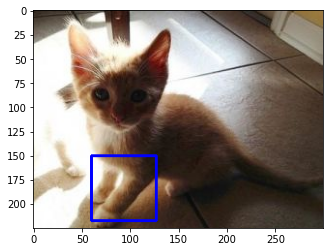

In [33]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalcatface.xml')

# load color (BGR) image
img = cv2.imread(cat_files[0])
print(img.shape)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray,1.1,4)
print(faces)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

------------------------

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [32]:
def face_detector(img_path):

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector


In [36]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


In [37]:
count = 0
for i in human_files_short:   
    if face_detector(i) == True:
        count = count + 1
percentage = (count/len(human_files_short))*100
print(percentage)

count = 0
for i in dog_files_short:   
    if face_detector(i) == True:
        count = count + 1
percentage = (count/len(dog_files_short))*100
print(percentage)

100.0
100.0


---
<a id='step2'></a>
## Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [38]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### Making Predictions with a Pre-trained Model



In [34]:
def VGG16_predict(image_path):

    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    VGG16.eval()
    # Predict the class of the image
    output = VGG16(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return index


In [39]:
VGG16_predict(dog_files_short[10])

253

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).


In [40]:
def dog_detector(img_path):
  
    class_id = VGG16_predict(img_path)
    if(class_id > 150 and class_id < 269):
        return True
    else: 
        return False

### Assess the Dog Detector



In [41]:
### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detector_v = np.vectorize(dog_detector)

human_detected_dog = dog_detector_v(human_files_short)
dog_detected = dog_detector_v(dog_files_short)

print("Percentage of dogs detected in humans dataset is",human_detected_dog.mean()*100,"%")
print("Percentage of dogs detected in dogs dataset is",dog_detected.mean()*100,"%")

Percentage of dogs detected in humans dataset is 1.0 %
Percentage of dogs detected in dogs dataset is 96.0 %


---
<a id='step3'></a>
## Create a CNN to Classify Dog Breeds



### Specify Data Loaders for the Dog Dataset


In [42]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


data_dir = '/content/drive/MyDrive/dogImages/dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

#test_files, test_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/test')
#train_files, train_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/train')
#valid_files, valid_targets = load_dataset('/content/drive/MyDrive/dogImages/dogImages/valid')

In [43]:
data_transforms = {
    'train' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [44]:
image_datasets = {
    'train' : ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : ImageFolder(root=test_dir,transform=data_transforms['test']),
}

In [45]:
data_loaders = {
    'train' : DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'],batch_size = batch_size)    
}

In [28]:
print("Size of training set is: "+str(len(image_datasets['train'])))
print("Size of validation set is: "+str(len(image_datasets['valid'])))
print("Size of testing set is: "+str(len(image_datasets['test'])))

Size of training set is: 6680
Size of validation set is: 835
Size of testing set is: 836


In [29]:
print("Number of classes are: "+str(len(image_datasets['train'].classes)))

Number of classes are: 133


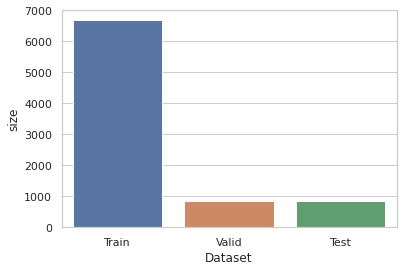

In [30]:
data_size = [['Train',len(image_datasets['train'])],['Valid',len(image_datasets['valid'])],['Test',len(image_datasets['test'])]]
df = pd.DataFrame(data_size,columns=['Dataset','size'])

sns.set(style="whitegrid")
ax = sns.barplot(x="Dataset", y="size", data=df)

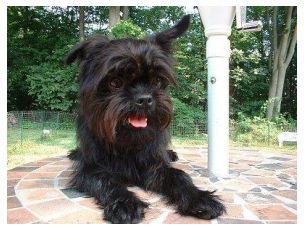

In [31]:
plt.axis('off')
plt.imshow(plt.imread(image_datasets['train'].imgs[0][0]))

In [32]:
path = '/content/drive/MyDrive/dogImages/dogImages/train'
images = []
titles = []
files = os.listdir(path)
for name in files:
    row = name.split(".")
    all_images = os.listdir(path+'/'+name)
    image = plt.imread(path+'/'+name+'/'+all_images[0])
    images.append(image)
    titles.append(row[1])
    continue


In [33]:

def show_images(images, cols = 1, titles = None):

    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        a.set_axis_off()
        plt.axis('off')
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [ ]:
#show_images(images[:6], 3, titles[:6])

In [46]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 6 * 6, 133)
        
        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        self.dropout = nn.Dropout(0.2)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)
        
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)
        
        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn6(x)
        
        x = x.view(-1, 256 * 6 * 6)
        
        x = self.dropout(x)
        x = self.fc1(x)


        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


- Using the six convolution layers all with the colvolution of size = 3, stride = 1 and padding = 0
- Relu activations are used after each convoltution layers except the last one.
- Max pooling layers of 2*2 are applied.
- Batch normalization is applied after each max pool layer. 
- Dropout is applied with the probability of 0.2.


### Specify Loss Function and Optimizer


In [47]:
# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

## Metrics
- Accuracy: Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Our probllem is a classificaition problem so measuring accuracy is important. 
- Loss: Loss is calculated for all three datasets to check if the model is underfitting/overfitting or not.If our training loss is much lower than validation loss then this means the network might be overfitting. Solutions to this are to decrease our network size, or to increase dropout. If training loss << validation loss , it is overfitting; if roughly training loss = validation loss , it is underfitting.

### Train and Validate the Model


In [48]:
def train(n_epochs, loaders, model, optimizer,scheduler, criterion, use_cuda, save_path):
 
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        # calculate average losses
        train_loss = train_loss/len(image_datasets['train'])
        valid_loss = valid_loss/len(image_datasets['valid'])

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [38]:
# train the model
loaders_scratch = data_loaders
n_epochs = 10


model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch,exp_lr_scheduler, 
                     criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 	Training Loss: 0.001074 	Validation Loss: 0.008034
Validation loss decreased (inf --> 0.008034).  Saving model ...
Epoch: 2 	Training Loss: 0.000863 	Validation Loss: 0.006532
Validation loss decreased (0.008034 --> 0.006532).  Saving model ...
Epoch: 3 	Training Loss: 0.000621 	Validation Loss: 0.005397
Validation loss decreased (0.006532 --> 0.005397).  Saving model ...
Epoch: 4 	Training Loss: 0.000472 	Validation Loss: 0.004884
Validation loss decreased (0.005397 --> 0.004884).  Saving model ...
Epoch: 5 	Training Loss: 0.000371 	Validation Loss: 0.005223
Epoch: 6 	Training Loss: 0.000296 	Validation Loss: 0.004885
Epoch: 7 	Training Loss: 0.000190 	Validation Loss: 0.004653
Validation loss decreased (0.004884 --> 0.004653).  Saving model ...
Epoch: 8 	Training Loss: 0.000160 	Validation Loss: 0.004584
Validation loss decreased (0.004653 --> 0.004584).  Saving model ...
Epoch: 9 	Training Loss: 0.000140 	Validation Loss: 0.004584
Epoch: 10 	Training Loss: 0.000126 	Valida

<All keys matched successfully>

### Test the Model


In [49]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Create a CNN to Classify Dog Breeds (using Transfer Learning)



### Specify Data Loaders for the Dog Dataset


In [41]:
# using the Data Loaders created above

### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [51]:
model_transfer = models.resnet18(pretrained=True)
print(model_transfer)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
for param in model_transfer.parameters():
    param.requires_grad = False


num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 133)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

In [53]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.001)

In [ ]:
loaders_transfer = data_loaders
n_epochs = 5
# train the model
train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, exp_lr_scheduler,criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model


In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### Predict Dog Breed with the Model

In [ ]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed

    image = Image.open(img_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()
    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    model_transfer.eval()
    # Predict the class of the image
    output = model_transfer(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return cat_to_name[str(index)]

In [ ]:
plt.axis('off')
plt.imshow(plt.imread(dog_files_short[10]))

In [ ]:
predict_breed_transfer(dog_files_short[10])


---
<a id='step5'></a>

- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
  
    plt.axis('off')
    plt.imshow(plt.imread(img_path))
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if(is_human):
        print("Human Face detected")
        print("It looks like the dog "+predict_breed_transfer(img_path))
        return
    elif(is_dog):
        print("It looks like the dog is of breed "+predict_breed_transfer(img_path))
        return
    else:
        print("Neither a human nor a dog")
        return


In [ ]:
run_app(human_files[0])

In [ ]:
run_app(human_files[1])

In [ ]:
run_app(human_files[2])

In [ ]:
run_app(dog_files[0])

In [ ]:
run_app(dog_files[1])

In [ ]:
run_app(dog_files[2])